## Blood data ViT

This project presents a Vision Transformer (ViT) model for automated blood cell classification using the BloodMNIST dataset from the MedMNIST collection. The implementation leverages transfer learning by initializing the Vision Transformer backbone with pre-trained DINO weights from a model previously trained on the LIDC medical imaging dataset. These pre-trained feature representations serve as a robust foundation, allowing the model to build upon existing learned patterns rather than starting from random initialization. The classification head is then fine-tuned specifically for the 8-class blood cell classification task (basophil, eosinophil, erythroblast, immunoglobulin, lymphocyte, monocyte, neutrophil, and platelet) on the BloodMNIST dataset. Additionally, the project incorporates comprehensive explainable AI (XAI) analysis to provide interpretable insights into the model's decision-making process. This implementation is based on tutorials available at [obzai github link](https://github.com/obzai/obzai). 


The task was to train a Vision Transformer model on any of MedMNIST datasets (except NoduleMNIST), followed by prediction and explanation.
Essentially apply the above steps with a different ViT model trained on one of the MedMNIST datasets.



In [ ]:
# !pip install obzai    #XAI library
# !pip install -q gdown
# !pip install -q medmnist

INFO: pip is looking at multiple versions of captum to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 854.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 

In [2]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.optim as optim
import numpy as np
import gdown
import os
from transformers import ViTConfig, ViTModel


from medmnist import BloodMNIST

# MODEL 

## ARCHITECTURE 

In [ ]:
class DINO(nn.Module):
    """
    DINO Transformer model based on Huggingface implementation.
    
    The model consists of:
    1. Backbone - pre-trained Vision Transformer (DINO)
    2. Classification head - linear layer for classifying 8 blood cell types
    
    Args:
        num_classes (int): Number of classes for classification (default 8 for BloodMNIST)
    """
    def __init__(self, num_classes=8):
        super().__init__()
        # Backbone
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager") # 'eager' implementation allows returning attention scores
        config.gradient_checkpointing = True
        #feature extraction from images
        self.backbone = ViTModel(config) 

        # Classfication head
        self.head = torch.nn.Linear(384, num_classes) #here the num_classes will be 8; 384 is the hidden_size for ViT-Small model

    def forward(self, x: torch.Tensor, output_attentions:bool=False):
        """
        Forward pass through the model.
        
        Args:
            x: Input image tensor [batch_size, channels, height, width]
            output_attentions: Whether to return attention maps (needed for XAI)
        
        Returns:
            logits: Classification results [batch_size, num_classes]
            attentions (optional): Attention maps from each layer
        """
        out = self.backbone(x, output_attentions=output_attentions)

        # Get CLS token representation (used for classification)
        x = out["pooler_output"]
        x = self.head(x)
        
        # Return results with attention maps 
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x

## IMAGE TRANSFORMATION PREPARATION


In [ ]:
#convert to tensor and resize to ViT size
TRANSFORMS = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(224, 224)),
])

NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


## DATA LOADING AND PREPARATION

In [ ]:
# Datasets
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

print("Loading Blood MedMNIST dataset...")
train_set = BloodMNIST(root=data_dir, split="train", transform=TRANSFORMS, download=True)
val_set = BloodMNIST(root=data_dir, split="val", transform=TRANSFORMS)
test_set = BloodMNIST(root=data_dir, split="test", transform=TRANSFORMS)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)


# CLASS DEFINITIONS AND MAPPING
# Labels mapping
CLASS_NAMES = [
    "basophil", "eosinophil", "erythroblast", "ig",
    "lymphocyte", "monocyte", "neutrophil", "platelet"
]

# Mapping indices to class names
LOGIT2NAME = {i: name for i, name in enumerate(CLASS_NAMES)}

print(f"Dataset sizes - Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
print(f"Number of classes: {len(CLASS_NAMES)}")



Loading Blood MedMNIST dataset...


100%|██████████| 35.5M/35.5M [00:02<00:00, 12.1MB/s]


Dataset sizes - Train: 11959, Val: 1712, Test: 3421
Number of classes: 8


## DATA SAMPLE VISUALIZATION

Visualizing training samples...


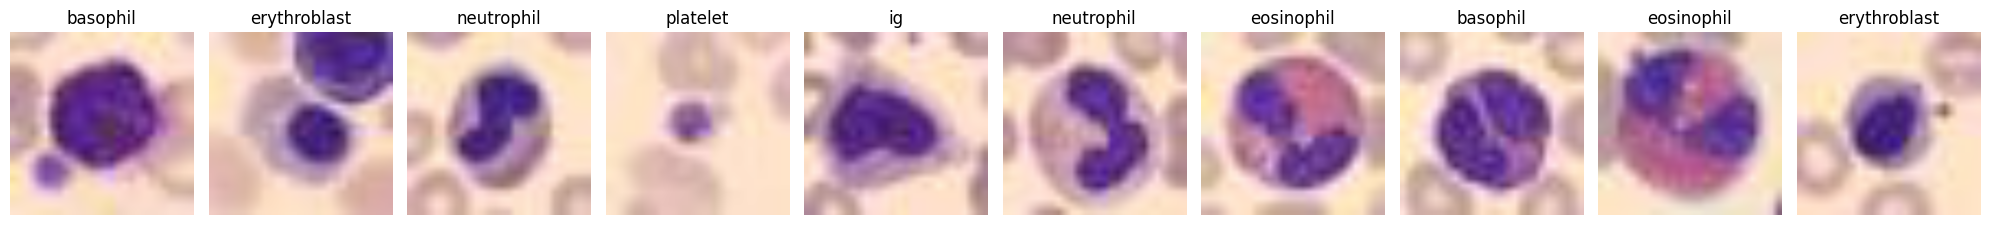

In [ ]:
def visualize_samples(dataloader, num_samples=10):
    """Visualize samples from the dataset"""
    # Get one batch of data
    samples, labels = next(iter(dataloader))

    fig, axes = plt.subplots(1, 10, figsize=(20, 5))
    axes = axes.flatten()

    for i in range(min(num_samples, len(samples))):
        # Convert tensor to numpy and change dimension order (C,H,W) -> (H,W,C)
        image = samples[i].permute(1, 2, 0).numpy()

        axes[i].imshow(image)
        axes[i].set_title(f"{CLASS_NAMES[labels[i].item()]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing training samples...")
visualize_samples(train_loader)

## MODEL INITIALIZATION AND TRAINING CONFIGURATION

In [7]:
def download_weights(url, output_dir, filename):
    """
    Downloads weights from the given URL if they are not already downloaded.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)

    if not os.path.exists(output_path):
        print(f"Downloading weights to {output_path}...")
        gdown.download(url, output_path)
    else:
        print(f"Weights already exist at {output_path}. Skipping download.")

url = "https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA"
output_dir = "tuned_models"
filename = "lidc_dino_s8.pth"
download_weights(url, output_dir, filename)

Downloading...
From (original): https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA
From (redirected): https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA&confirm=t&uuid=fba9a8aa-e576-48c9-9ae4-d9c5f6d6a811
To: /content/tuned_models/lidc_dino_s8.pth
100%|██████████| 87.4M/87.4M [00:03<00:00, 22.2MB/s]


In [ ]:
# Check GPU availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Initialize DINO model and load weights
WEIGHTS_PATH = "./tuned_models/lidc_dino_s8.pth"
MODEL = DINO(num_classes=len(CLASS_NAMES))

# Preprocessing weights
# checkpoint
checkpoint = torch.load(WEIGHTS_PATH, weights_only=True, map_location=torch.device(DEVICE))
current_model_dict = MODEL.state_dict()

# only matching weights
filtered_checkpoint = {
    k: v for k, v in checkpoint.items()
    if k in current_model_dict and v.size() == current_model_dict[k].size()
}

# filtered weights
MODEL.load_state_dict(filtered_checkpoint, strict=False)
MODEL = MODEL.to(DEVICE)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

In [ ]:
# Training configuration
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(MODEL.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Function to train the model for one epoch.
    
    Args:
        model: Model to train
        dataloader: DataLoader with training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device (CPU/GPU)
    
    Returns:
        avg_loss: Average loss for the epoch
        accuracy: Accuracy for the epoch in percentage
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        target = target.squeeze()  # Remove extra dimension if present

        # Apply normalization
        data = NORMALIZE(data)

        # Zero gradients, forward pass, backward pass, and optimization step
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Accumulate statistics
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')

    return total_loss / len(dataloader), 100. * correct / total

# Validation function
def validate(model, dataloader, criterion, device):
    """
    Function to validate the model.
    
    Args:
        model: Model to evaluate
        dataloader: DataLoader with validation data
        criterion: Loss function
        device: Device (CPU/GPU)
    
    Returns:
        avg_loss: Average validation loss
        accuracy: Validation accuracy in percentage
    """
    model.eval() # disables dropout, batch norm
    total_loss = 0
    correct = 0
    total = 0

    # disable gradient computation for speed and memory savings
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze()

            data = NORMALIZE(data)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    return total_loss / len(dataloader), 100. * correct / total


## TRAINING LOOP

In [ ]:
print("Starting training...")
NUM_EPOCHS = 5 # I trained for 5 epochs, bc of my limited comp resources
best_val_acc = 0

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Training
    train_loss, train_acc = train_epoch(MODEL, train_loader, criterion, optimizer, DEVICE)

    # Validation
    val_loss, val_acc = validate(MODEL, val_loader, criterion, DEVICE)

    # Learning rate scheduling
    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save the model
    model_path = f"./blood_vit_model{epoch}.pth"
    torch.save(MODEL.state_dict(), model_path)


Starting training...

Epoch 1/5
Batch 0/374, Loss: 2.2450
Batch 10/374, Loss: 1.1462
Batch 20/374, Loss: 0.8777
Batch 30/374, Loss: 0.7727
Batch 40/374, Loss: 0.7100
Batch 50/374, Loss: 0.6810
Batch 60/374, Loss: 0.8250
Batch 70/374, Loss: 0.9304
Batch 80/374, Loss: 0.6612
Batch 90/374, Loss: 0.7203
Batch 100/374, Loss: 0.8795
Batch 110/374, Loss: 0.8287
Batch 120/374, Loss: 0.7209
Batch 130/374, Loss: 0.7249
Batch 140/374, Loss: 0.6014
Batch 150/374, Loss: 0.7812
Batch 160/374, Loss: 0.7787
Batch 170/374, Loss: 0.6980
Batch 180/374, Loss: 0.7108
Batch 190/374, Loss: 0.8584
Batch 200/374, Loss: 0.5914
Batch 210/374, Loss: 0.6682
Batch 220/374, Loss: 0.7898
Batch 230/374, Loss: 0.5951
Batch 240/374, Loss: 0.5978
Batch 250/374, Loss: 0.7805
Batch 260/374, Loss: 0.8219
Batch 270/374, Loss: 0.6279
Batch 280/374, Loss: 0.6299
Batch 290/374, Loss: 0.5840
Batch 300/374, Loss: 0.6128
Batch 310/374, Loss: 0.6324
Batch 320/374, Loss: 0.5107
Batch 330/374, Loss: 0.6286
Batch 340/374, Loss: 0.5483

## TRAINING HISTORY VISUALIZATION

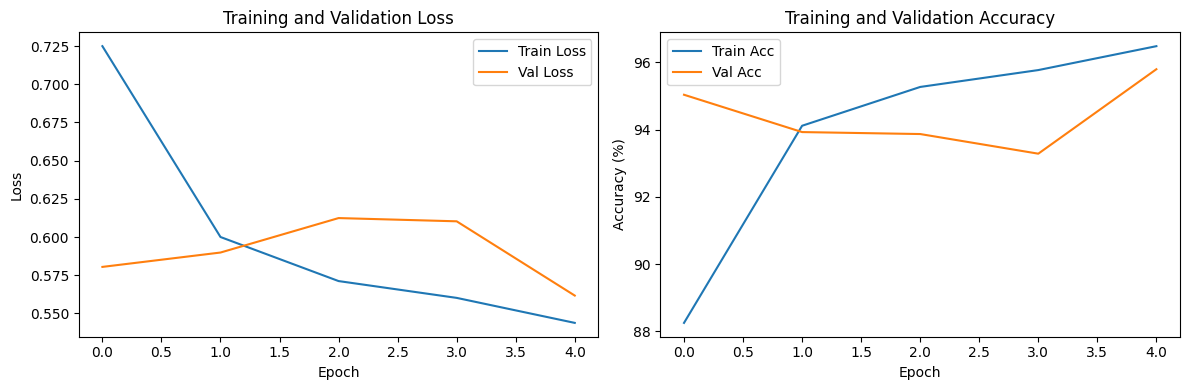

In [ ]:
#loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

#acuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## LOADING BEST MODEL AND EVALUATION

In [14]:
# Load best model for evaluation
best_model_path = "./blood_vit_model4.pth"
print(f"\nLoading best model (Val Acc: {best_val_acc:.2f}%)...")
MODEL.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
MODEL.eval()


Loading best model (Val Acc: 95.79%)...


DINO(
  (backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
            (intermediate_act_fn): GELUAc

In [16]:
print("\nClassification Report:")
test_loss, test_acc = validate(MODEL, test_loader, criterion, DEVICE)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Classification Report:
Test Loss: 0.5573, Test Acc: 95.85%


In [ ]:
# Test evaluation
def evaluate_model(model, dataloader, device):
    """
    Function for detailed model evaluation.
    Returns all predictions and true labels.
    """
     
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze()

            data = NORMALIZE(data)
            output = model(data)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

print("Evaluating on test set...")
test_preds, test_targets = evaluate_model(MODEL, test_loader, DEVICE)

Evaluating on test set...


## PREDICTIONS WITH ATTENTION MAP VISUALIZATION


Generating predictions and explanations...


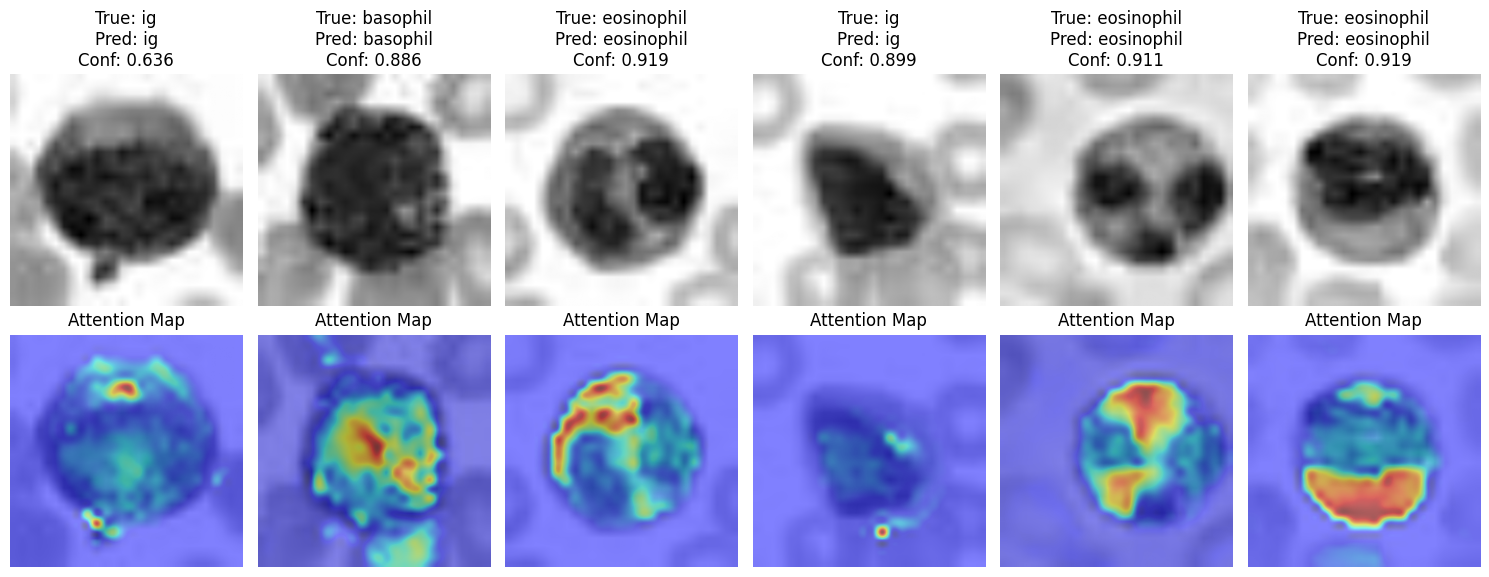

In [ ]:
def predict_and_explain_batch(model, dataloader, device, num_samples=6):
    """Make predictions and generate explanations for a batch"""
    model.eval()

    # Get a batch
    data_batch, target_batch = next(iter(dataloader))
    data_batch = data_batch[:num_samples].to(device)
    target_batch = target_batch[:num_samples].squeeze()

    with torch.no_grad():
        # Normalize input
        normalized_data = NORMALIZE(data_batch)

        # Get predictions and attention
        logits, attentions = model(normalized_data, output_attentions=True)
        predictions = torch.softmax(logits, dim=1)
        predicted_classes = predictions.argmax(dim=1)

        # Get last layer attention
        last_attention = attentions[-1].mean(dim=1)  # Average across attention heads

        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

        for i in range(num_samples):
            # Original image
            img = data_batch[i].cpu().permute(1, 2, 0).numpy()
            if img.shape[2] == 3:
                img = img[:, :, 0]  # Take first channel
            else:
                img = img.squeeze()

            axes[0, i].imshow(img, cmap='gray')
            true_class = CLASS_NAMES[target_batch[i].item()]
            pred_class = CLASS_NAMES[predicted_classes[i].item()]
            confidence = predictions[i].max().item()

            axes[0, i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}')
            axes[0, i].axis('off')

            # Attention map (CLS token attention to patches)
            cls_attention = last_attention[i, 0, 1:].cpu().numpy() 

            # Reshape attention to spatial dimensions
            patch_size = int(np.sqrt(len(cls_attention)))
            if patch_size * patch_size == len(cls_attention):
                attention_map = cls_attention.reshape(patch_size, patch_size)

                # Resize attention map to match input image size
                from scipy.ndimage import zoom
                attention_resized = zoom(attention_map, (img.shape[0] / patch_size, img.shape[1] / patch_size))

                axes[1, i].imshow(img, cmap='gray', alpha=0.7)
                axes[1, i].imshow(attention_resized, cmap='jet', alpha=0.5)
                axes[1, i].set_title('Attention Map')
            else:
                axes[1, i].text(0.5, 0.5, 'Attention\nVisualization\nError',
                               ha='center', va='center', transform=axes[1, i].transAxes)

            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    return predictions, predicted_classes, attentions

print("\nGenerating predictions and explanations...")
predictions, pred_classes, attentions = predict_and_explain_batch(MODEL, test_loader, DEVICE)


# ADVANCED XAI ANALYSIS

In [ ]:
from obzai.xai.eval_tool import Fidelity, Compactness
import matplotlib.pyplot as plt
from obzai.xai.xai_tool import CDAM, SaliencyMap, AttentionMap
from obzai.xai.xai_regions import XAIRegions
from obzai.data_inspector.extractor import FirstOrderExtractor
from obzai.data_inspector.detector import GMMDetector
from obzai.xai import xai_utils


## OUTLIER DETECTION TOOLS INITIALIZATION

In [ ]:
# Choose desired feature extractor. Chosen extractor will be used for monitoring.
first_order_extrc = FirstOrderExtractor()

# Pass choosen extractor(s) to chosen OutlierDetector. Below we utilize outlier detector based on Gaussian Mixture Models.
gmm_detector = GMMDetector(extractors=[first_order_extrc], n_components=3, outlier_quantile=0.01)

# Method will extract desired image features and fit outlier detection model (in that case GMM).
gmm_detector.fit(val_loader)

## CDAM, AttentionMap, SmoothGrad, XAIRegions 

In [ ]:
#class-specific attention maps
cdam_tool = CDAM(model=MODEL,
                 mode='vanilla',
                 gradient_type="from_probabilities",
                 gradient_reduction="average",
                 activation_type="softmax")
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.11.layernorm_before")

#smooth_grad
smooth_grad_tool = SaliencyMap(model=MODEL, mode="vanilla")

# attention maps
attention_tool = AttentionMap(model=MODEL)

# XAIRegions:
# Wraps existing XAI tools to merges attribution scores with pixel regions to achieve more visually appealing XAI maps.
xai_regions_tool = XAIRegions()

# XAIEval:
# Fidelity - measures explanation faithfulness (does removing important pixels affect prediction)
fidelity_tool = Fidelity(model=MODEL, device=DEVICE) 
# Compactness - measures attention compactness (is attention focused or scattered)
compactness_tool = Compactness()

Using device: cuda


In [ ]:
# Get fresh batch of images
image_batch, _ = next(iter(test_loader))
image_batch = image_batch[:3]

# Make prediction
with torch.no_grad():
    norm_image_batch = NORMALIZE(image_batch).to(DEVICE)
    logits = MODEL(norm_image_batch)
    max_logits_idxs = torch.argmax(logits, dim=1).cpu().tolist()
    probabilities = torch.nn.functional.softmax(logits, dim=1)

# Achieving XAI maps. You can specify for which logit you want to achieve explanations!
cdam_maps = cdam_tool.explain(norm_image_batch, target_idx=max_logits_idxs)
smooth_grad_maps = smooth_grad_tool.explain(norm_image_batch, target_idx=max_logits_idxs)
attention_maps = attention_tool.explain(norm_image_batch)

# Region-based XAI maps
cdam_regions_maps = xai_regions_tool.regionize(raw_images=image_batch, attribution_maps=cdam_maps)
attention_regions_maps = xai_regions_tool.regionize(raw_images=image_batch, attribution_maps=attention_maps)

In [24]:
# Evaluating the XAI method
scores_fid = fidelity_tool.score(image_batch, cdam_maps, target_logits=max_logits_idxs)
scores_comp = compactness_tool.score(cdam_maps)
print("Fidelity: ", scores_fid[:3])
print("Compactness: ", scores_comp[:3])

Fidelity:  [-0.10216332077980042, 0.0018733769655227646, -0.11060075433924796]
Compactness:  [0.6530612244897959, 0.7397959183673469, 0.7308673469387755]


## GENERATE DIFFERENT TYPES OF XAI MAP

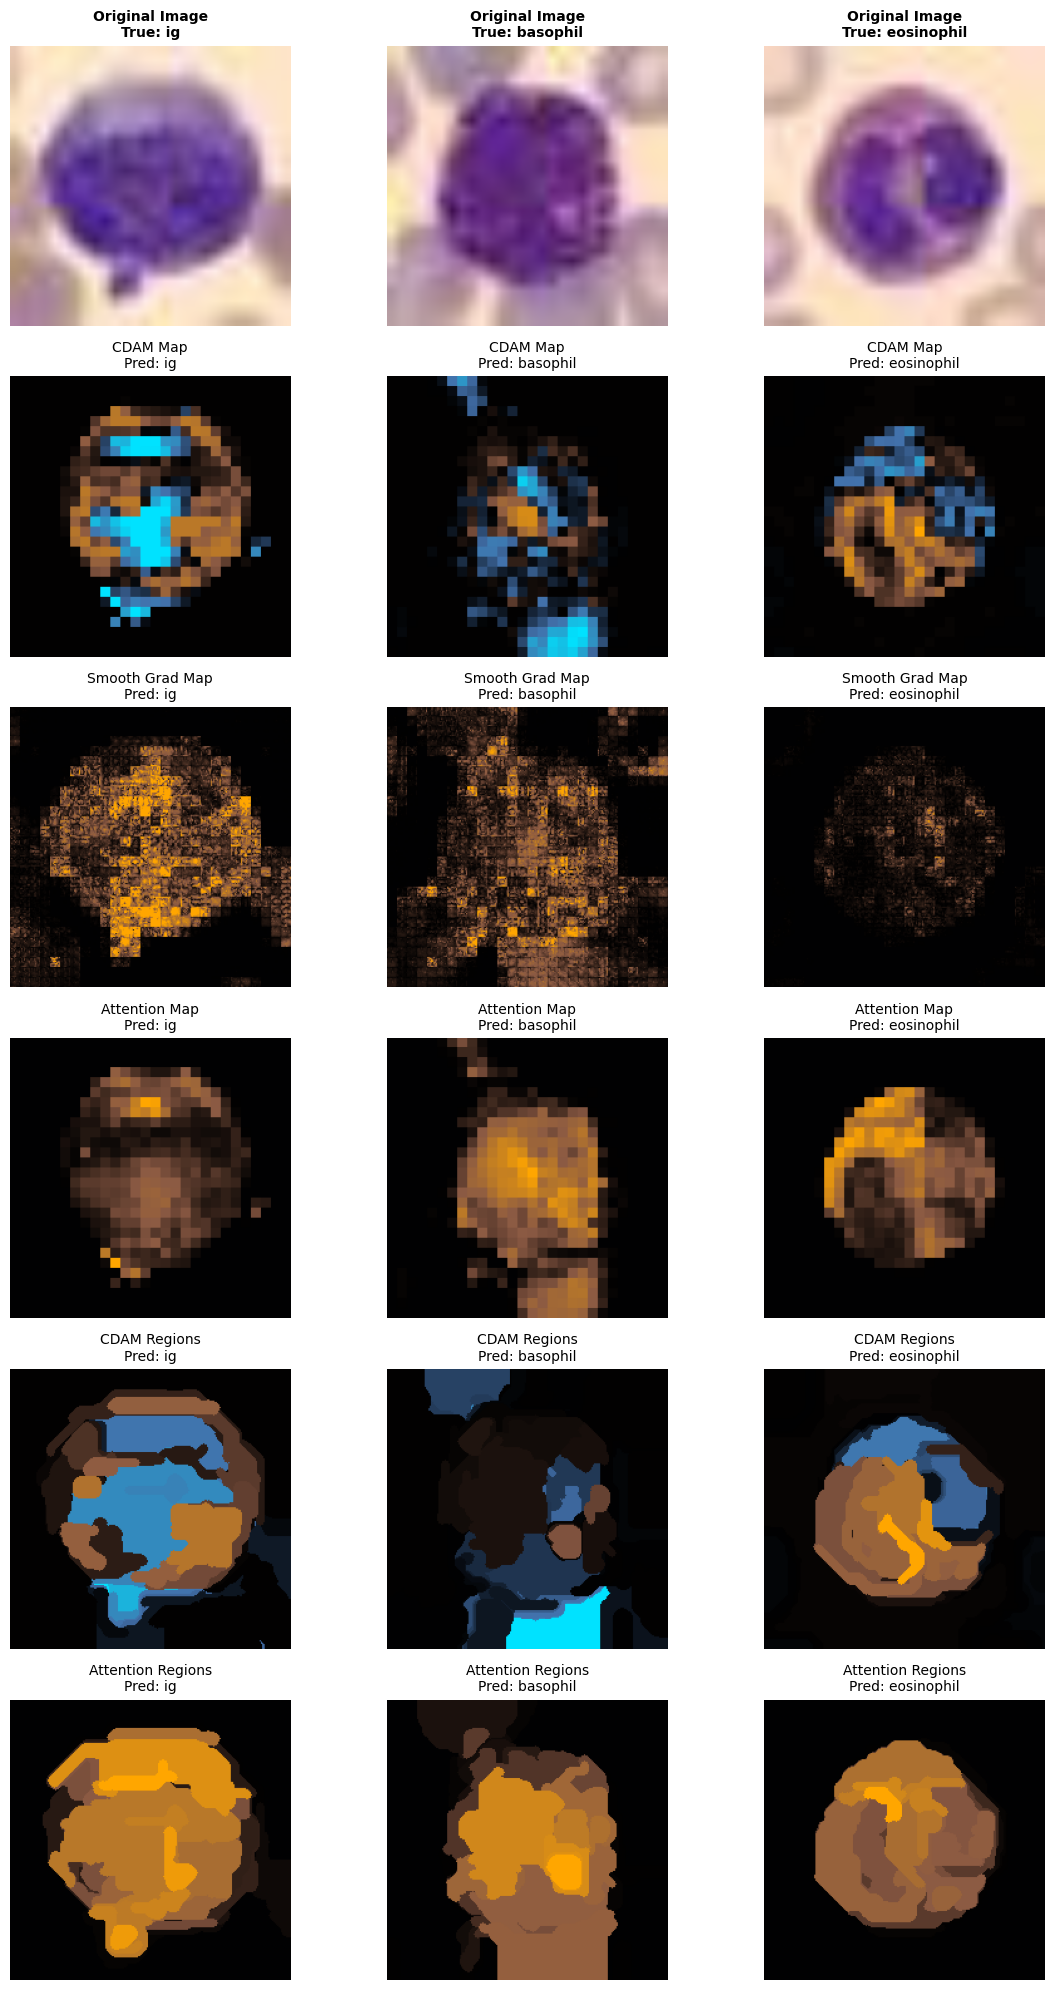

In [ ]:
# Normalizing maps for visualization
norm_cdam_maps = xai_utils.normalize_xai_maps(cdam_maps)
norm_smooth_grad_maps = xai_utils.normalize_xai_maps(smooth_grad_maps)
norm_attention_maps = xai_utils.normalize_xai_maps(attention_maps)
norm_cdam_regions_map = xai_utils.normalize_xai_maps([map_ for map_ in cdam_regions_maps])
norm_attention_regions_map = xai_utils.normalize_xai_maps([map_ for map_ in attention_regions_maps])

# Get true labels for the batch
_, true_labels_batch = next(iter(test_loader))
true_labels = true_labels_batch[:3].squeeze()

# Plotting the normalized XAI maps with true classes
fig, axs = plt.subplots(6, 3, figsize=(12, 20))

for example_idx in range(3):
    # Get true and predicted classes
    true_class = CLASS_NAMES[true_labels[example_idx].item()]
    pred_class = CLASS_NAMES[max_logits_idxs[example_idx]]

    # Original image
    axs[0][example_idx].imshow(image_batch[example_idx].movedim((0,1,2),(2,0,1)).numpy())
    axs[0][example_idx].set_title(f"Original Image\nTrue: {true_class}",
                                  fontsize=10, fontweight='bold')
    axs[0][example_idx].axis('off')

    # CDAM map  - shows which areas are important for given class
    axs[1][example_idx].imshow(norm_cdam_maps[example_idx])
    axs[1][example_idx].set_title(f"CDAM Map\nPred: {pred_class}", fontsize=10)
    axs[1][example_idx].axis('off')

    # SmoothGrad map - smoothed gradients showing important pixels
    axs[2][example_idx].imshow(norm_smooth_grad_maps[example_idx])
    axs[2][example_idx].set_title(f"Smooth Grad Map\nPred: {pred_class}", fontsize=10)
    axs[2][example_idx].axis('off')

    # Attention map
    axs[3][example_idx].imshow(norm_attention_maps[example_idx])
    axs[3][example_idx].set_title(f"Attention Map\nPred: {pred_class}", fontsize=10)
    axs[3][example_idx].axis('off')

    #combined with region segmentation:

    # CDAM Regions
    axs[4][example_idx].imshow(norm_cdam_regions_map[example_idx])
    axs[4][example_idx].set_title(f"CDAM Regions\nPred: {pred_class}", fontsize=10)
    axs[4][example_idx].axis('off')

    # Attention Regions
    axs[5][example_idx].imshow(norm_attention_regions_map[example_idx])
    axs[5][example_idx].set_title(f"Attention Regions\nPred: {pred_class}", fontsize=10)
    axs[5][example_idx].axis('off')

plt.tight_layout()
plt.show()
